## Testing PCA feature extractor.

Much faster fitting.

In [2]:
%load_ext autoreload
%autoreload 3 --print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
import os, sys, shutil
from pprint import pprint
from kpsn import viz
from kpsn.viz import styles
import matplotlib.pyplot as plt
plotter, colors = styles.init_nb("vscode_dark")

import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
project_dir = '../projects/pca-feat'
project = Project(project_dir)

# if os.path.exists(project_dir): shutil.rmtree(project_dir)
if not os.path.exists(project_dir):
    loaders.raw_npy.setup_project_config(
        project,
        filepaths = {
            '24wk_m3': '../../../data_explore/data/11_03_22_24wk_m3.npy',
            '5wk_m6': '../../../data_explore/data/10_24_22_5wk_m6.npy'},
        ref_session = '24wk_m3',
        keypoint_names = [
            'shldr', 'back', 'hips', 't_base','t_tip', 'head',
            'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
            'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
        keypoint_parents = [
            'back', 'hips', None, 'hips', 'shldr',
            'head', 'head', 'head', 'hips', 'lr_knee',
            'hips', 'rr_knee', 'shldr', 'shldr'],
        exclude_keypoints = ['t_tip'],
        subsample = 10,
        feature_type='pcs',)
    
    setup.setup_base_model_config(project)

In [12]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.raw_npy.load(cfg["dataset"])

dataset, cfg = loaders.raw_npy.default_alignment.calibrate(
    project, dataset, cfg, origin="hips", anterior="head"
)

cfg = features.pcs.calibrate(project, dataset, cfg)
dataset = features.reduce_to_features(
    dataset, cfg["features"]
)
config.save_project_config(project.main_config(), cfg, write_calib=True)

cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["calibration"]["tgt_variance"] = 0.95

cfg = pose.gmm.calibrate_base_model(project, dataset, cfg, n_components=5)
cfg = morph.lowrank_affine.calibrate_base_model(project, dataset, cfg)
cfg = em.calibrate_base_model(project, dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

Reloading 'kpsn.models.morph.lowrank_affine'.


Reloading 'kpsn.models.pose.gmm'.
['type', 'n_components', 'ref_session', 'diag_eps', 'pop_weight_uniformity', 'subj_weight_uniformity', 'wish_var', 'wish_dof', 'logit_max', 'init', 'calibration', 'calibration_data']


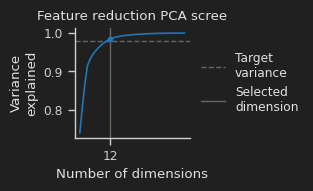

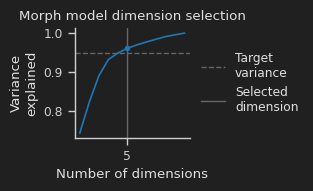

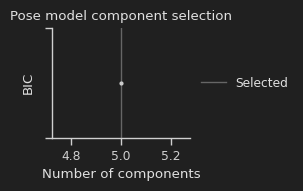

In [16]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(project, cfg)
plotter.finalize(fig, None)

calibration_plots = viz.model.plot_calibration(project, cfg)
plotter.finalize(calibration_plots["morph"], None, display = False)
plotter.finalize(calibration_plots["pose"], None, display = False)
plt.show()

### Single model

In [6]:
model_dir, cfg = create_model(
    project,
    "first_run",
    config_overrides={
        "fit.learning_rate": 8,
        "fit.n_steps": 100,
    },
)
fit_data = methods.fit(
    project.model("first_run"),
    log_every=1,
)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 3592 frames
INFO:root:Adjusting learning rate:8 -> 0.0011134307585247043
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 286143.3125
INFO:root:Step 1 : loss = 285267.75
INFO:root:Step 2 : loss = 284709.125
INFO:root:Step 3 : loss = 284252.6875
INFO:root:Step 4 : loss = 283847.8125
INFO:root:Step 5 : loss = 283478.71875
INFO:root:Step 6 : loss = 283141.875
INFO:root:Step 7 : loss = 282834.5625
INFO:root:Step 8 : loss = 282553.3125
INFO:root:Step 9 : loss = 282295.03125
INFO:root:Step 10 : loss = 282058.21875
INFO:root:Step 11 : loss = 281841.40625
INFO:root:Step 12 : loss = 281646.84375
INFO:root:Step 13 : loss = 281474.03125
INFO:root:Step 14 : loss = 281322.84375
INFO:root:Step 15 : loss = 281192.9375
INFO:root:Step 16 : loss = 281084.65625
INFO:root:Step 17 : loss = 280998.25
INFO:root:Step 18 : loss = 280935.4375
INFO:root:Step 19 : loss = 280900.75
INFO:root:Step 20 : loss =

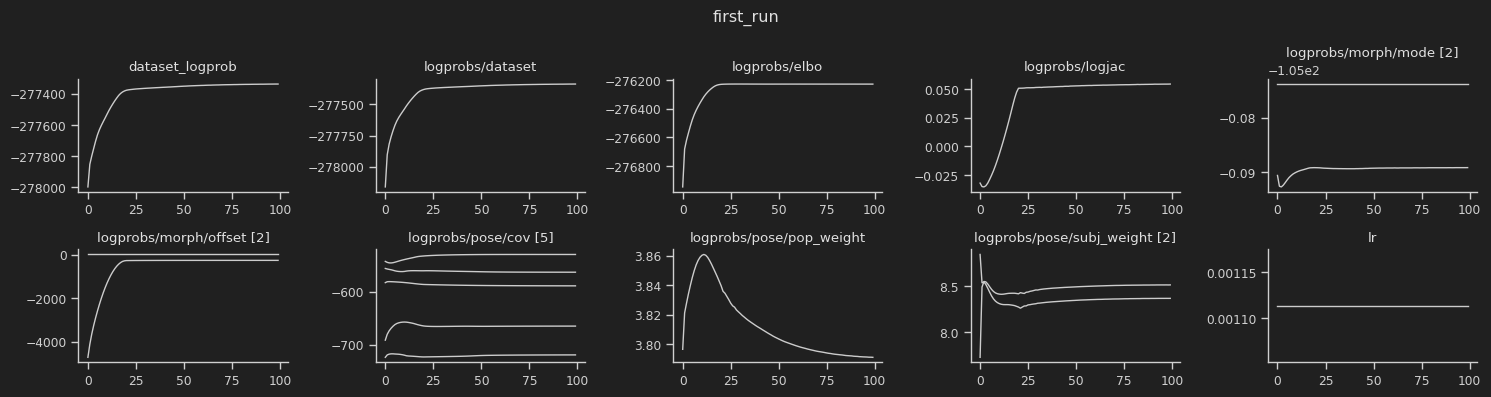

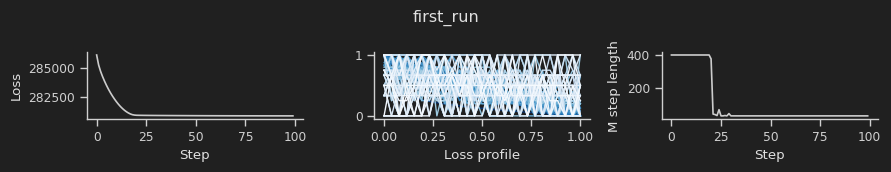

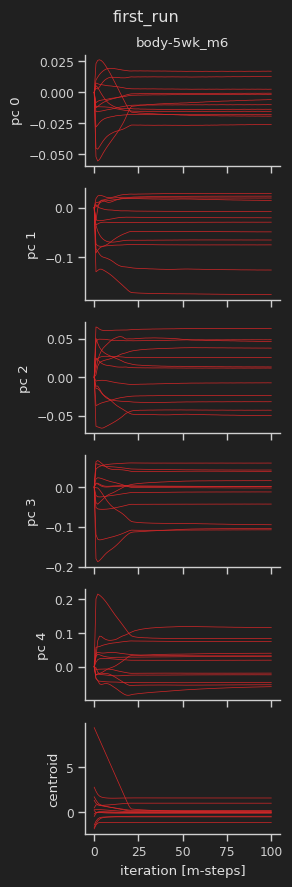

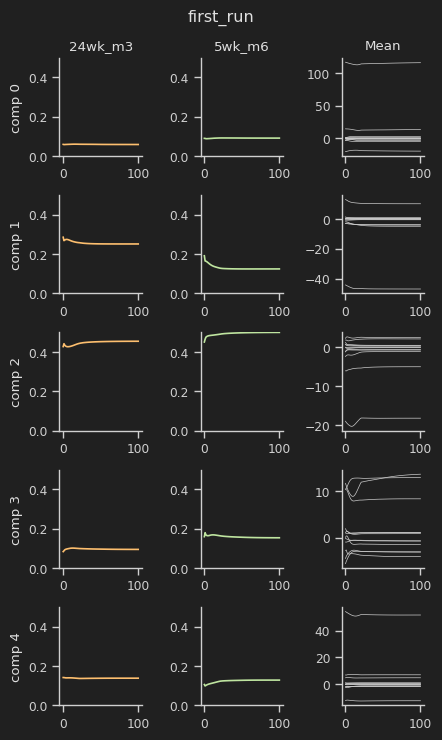

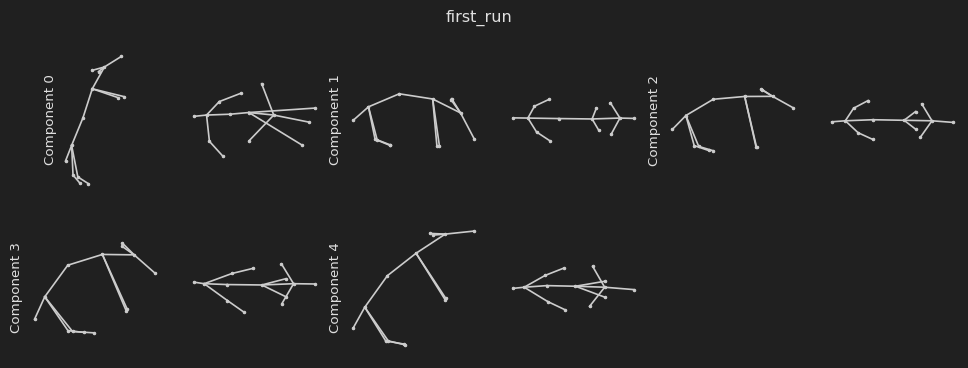

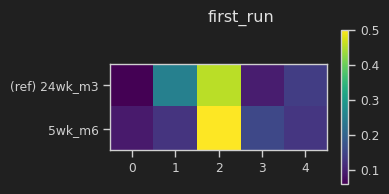

In [18]:
model_name = "first_run"
ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.report_plots(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.em_loss(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.lra_param_convergence(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.gmm_param_convergence(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
mean_fig, wt_fig = viz.model.gmm_components(ckpt)
mean_fig.suptitle(model_name)
wt_fig.suptitle(model_name)
plotter.finalize(fig, None)

Reloading 'kpsn.viz.model'.


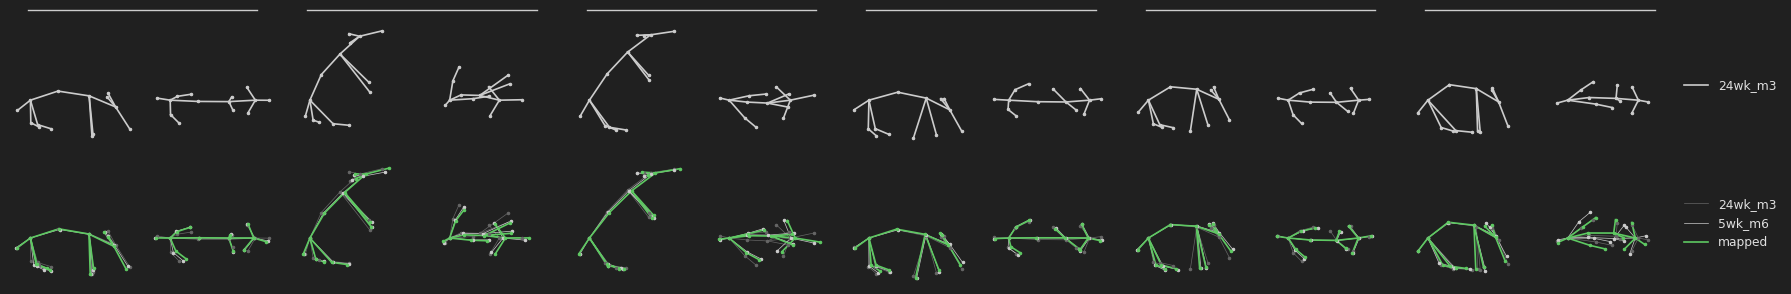

In [35]:
ckpt = methods.load_fit(project.model("first_run"))
fig = viz.model.compare_nearest_frames(ckpt, group_lines=True)
plotter.finalize(fig, None, despine = False, tight=False)

### Scan (split fit matching single model params)

In [19]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "prior-scan", {
    'morph.upd_var_modes': [1e-3, 3e-2, 3e-1, 3e0],
    'morph.upd_var_ofs': [5e-3, 1e-1, 1e0, 1e1],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 100,
})
scans.run_scan(project, "prior-scan", log_every=1)

Reloading 'kpsn.config'.


INFO:root:Model at ../projects/pca-feat/models/prior-scan_0 is already up to date.
INFO:root:Model at ../projects/pca-feat/models/prior-scan_1 is already up to date.
INFO:root:Model at ../projects/pca-feat/models/prior-scan_2 is already up to date.
INFO:root:Model at ../projects/pca-feat/models/prior-scan_3 is already up to date.


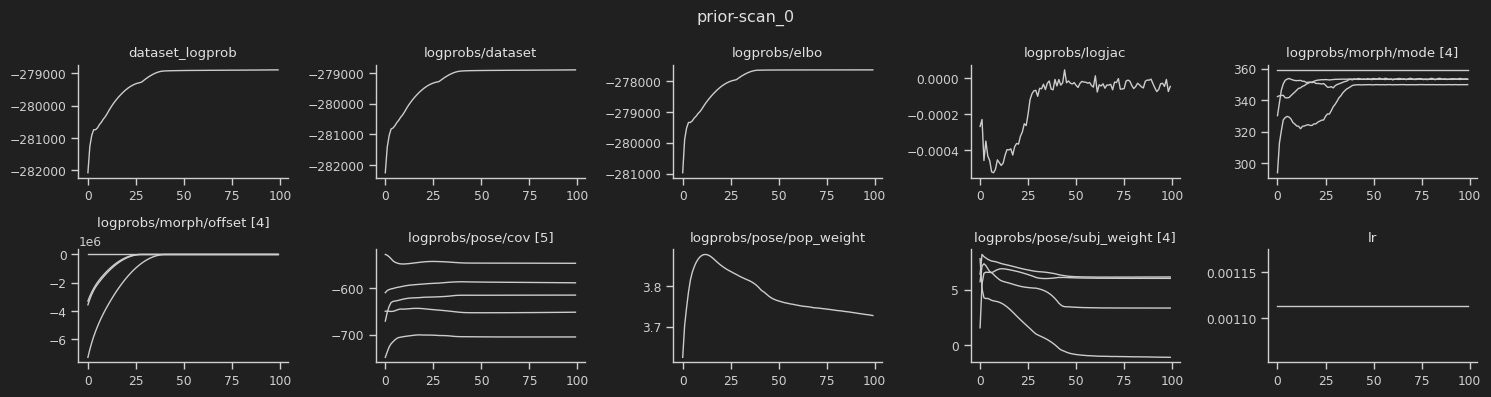

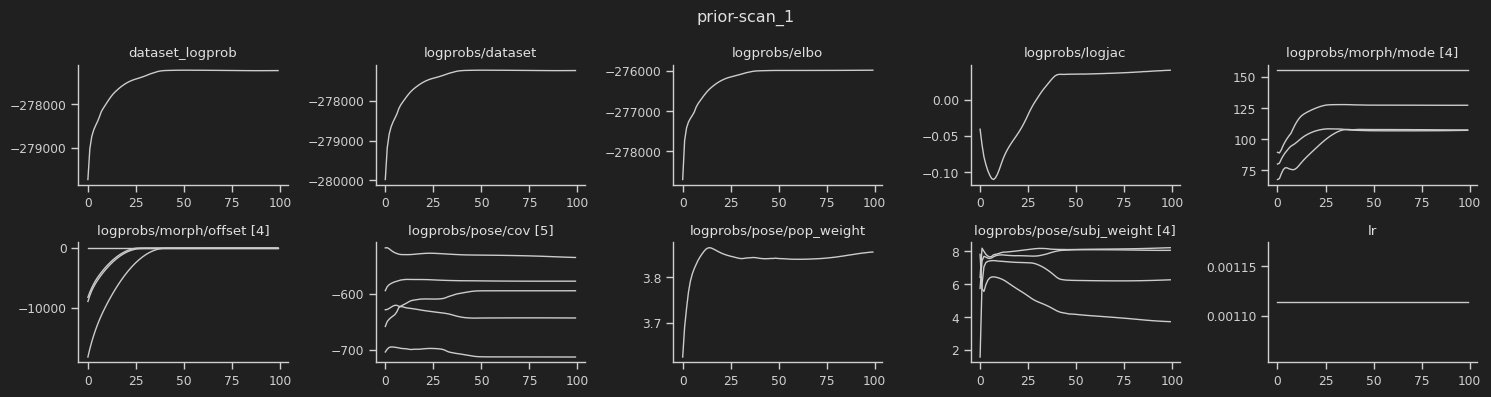

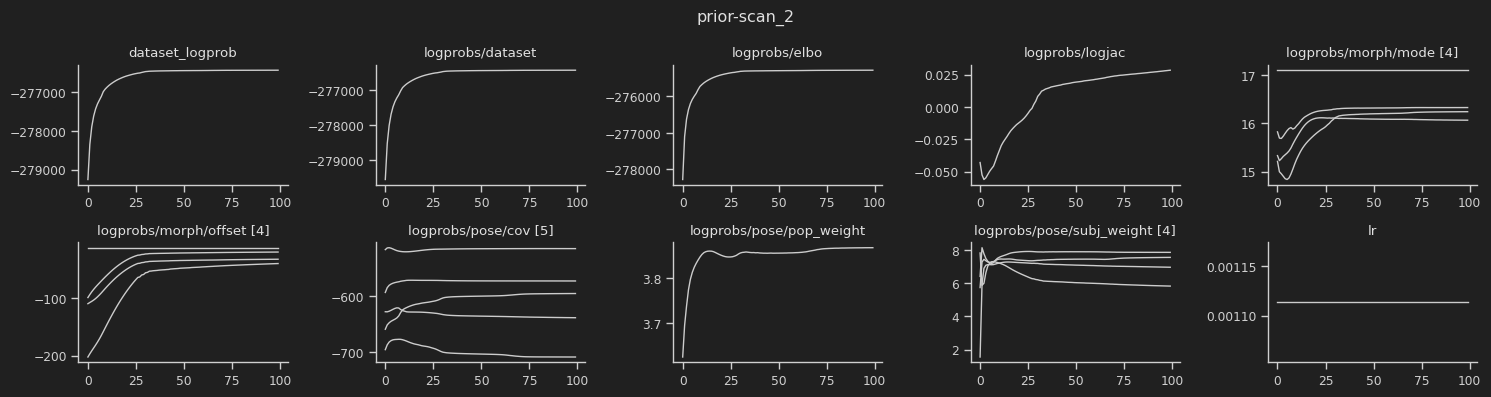

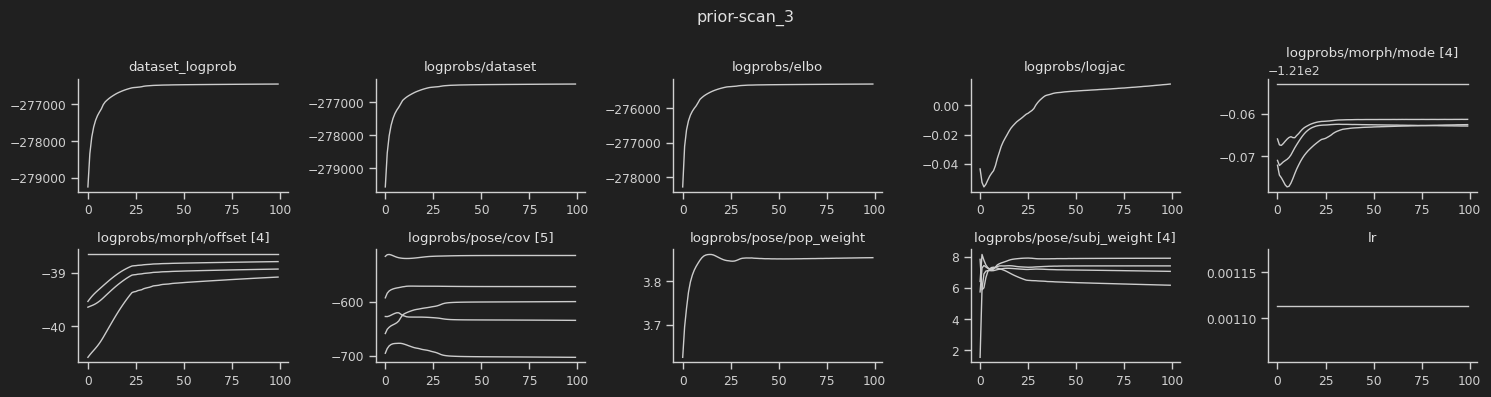

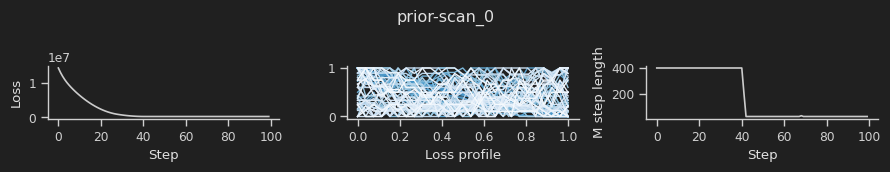

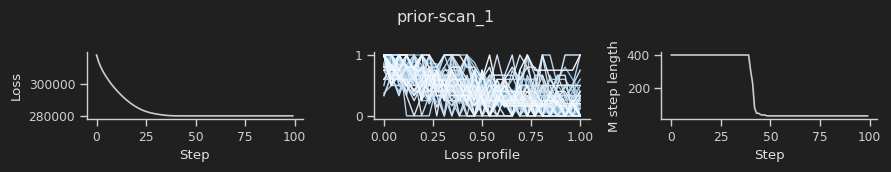

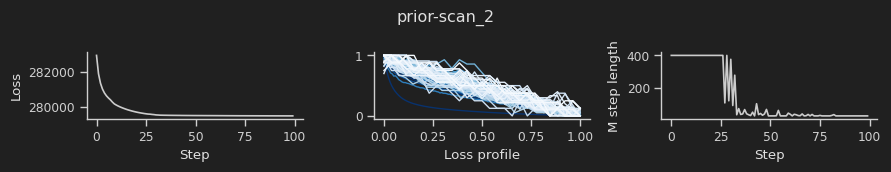

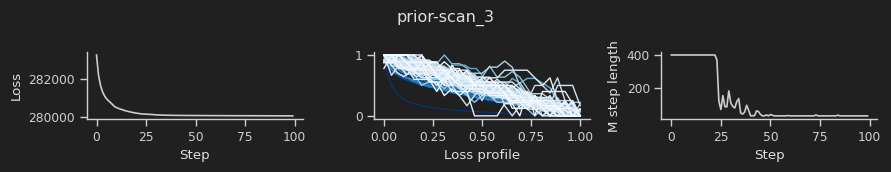

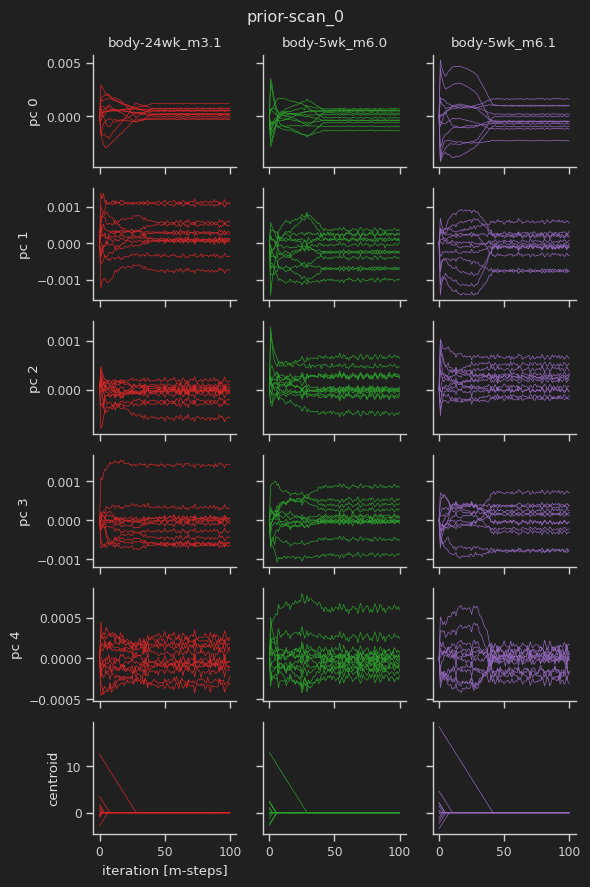

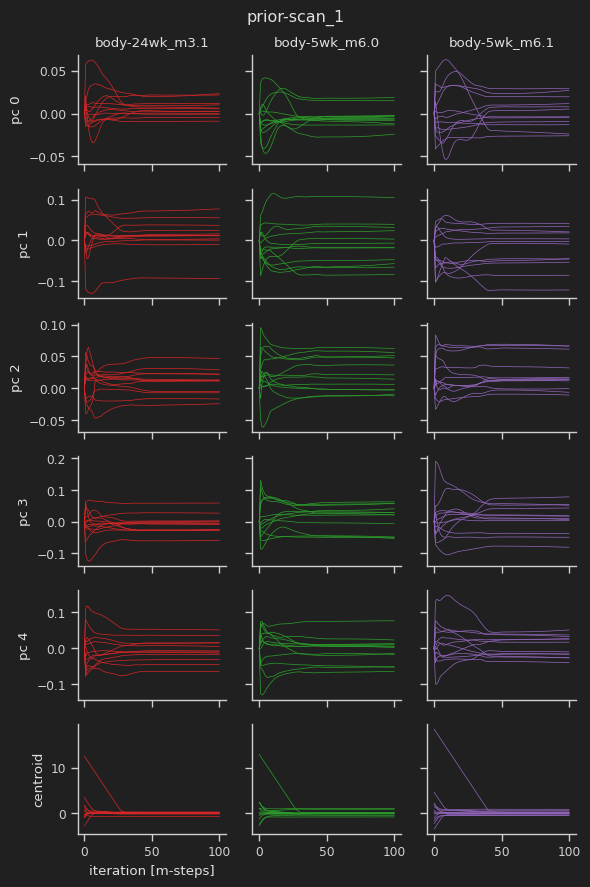

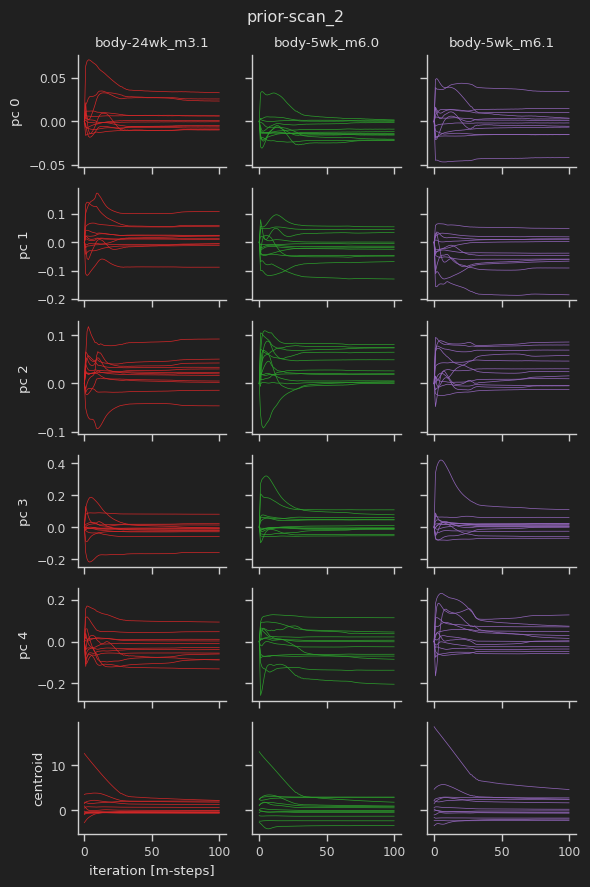

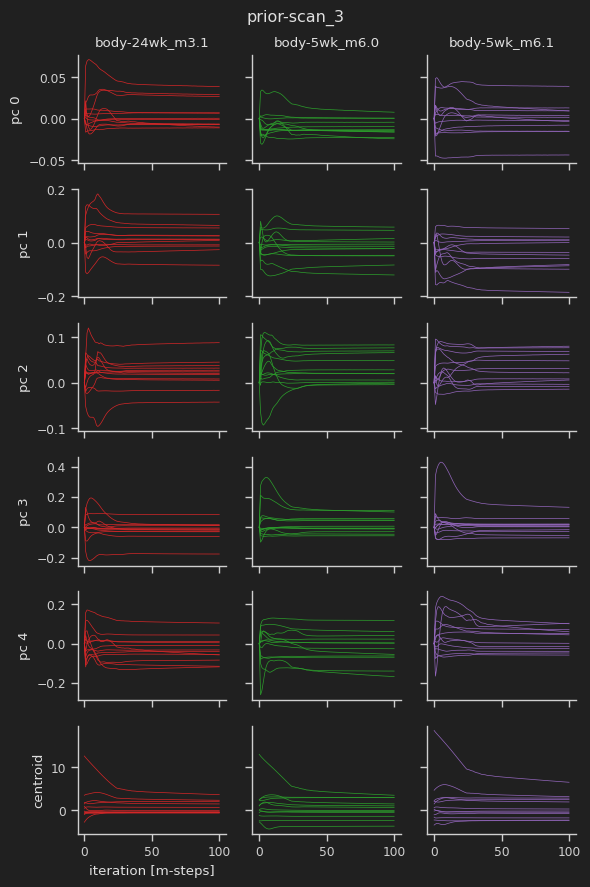

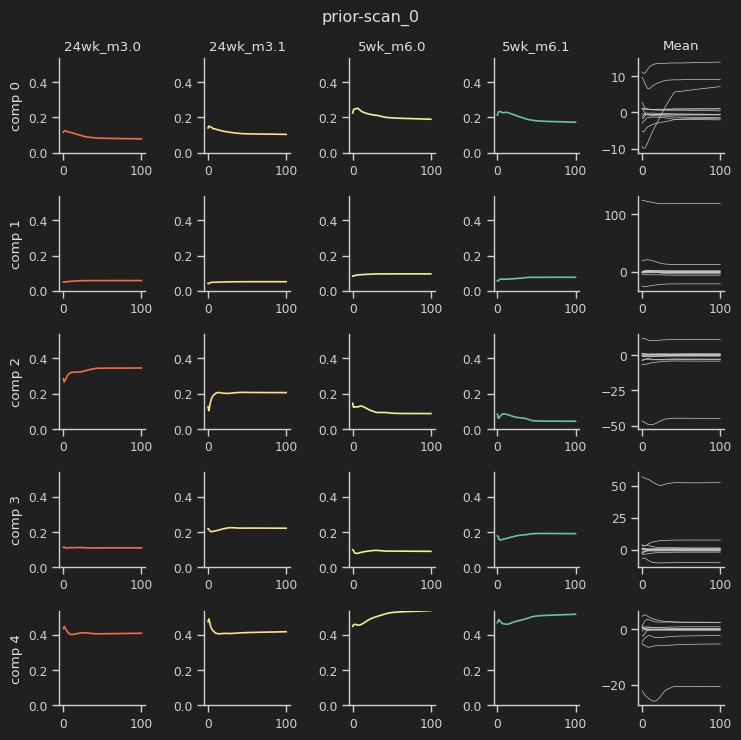

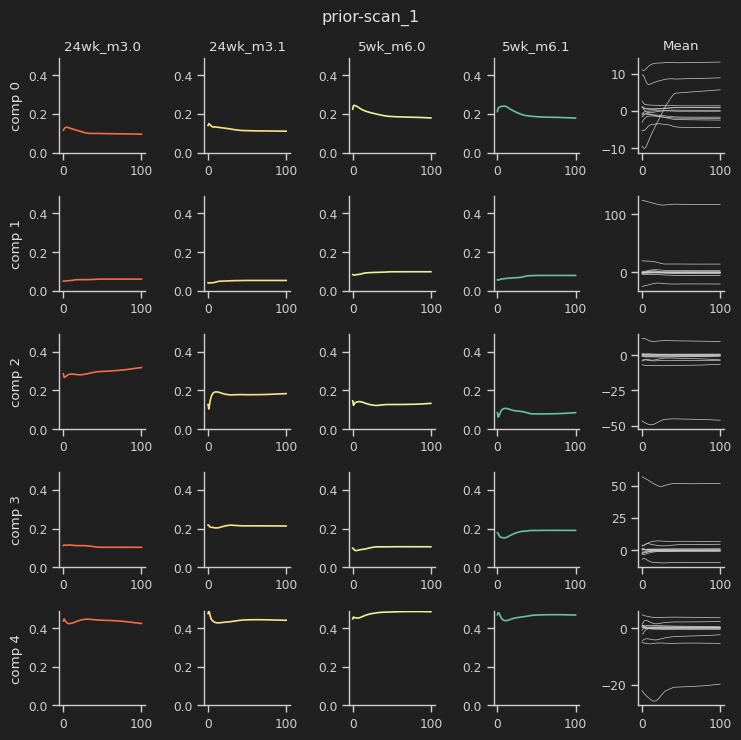

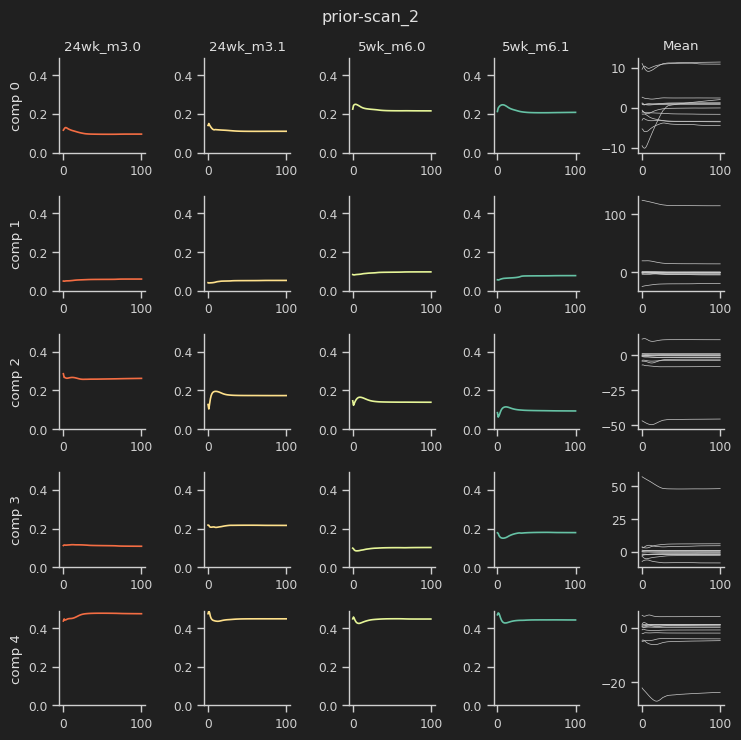

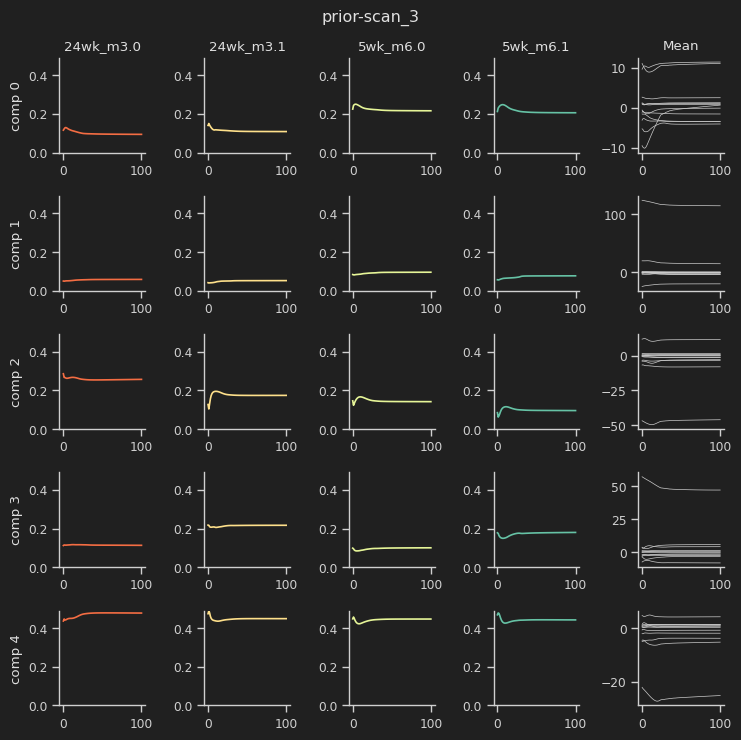

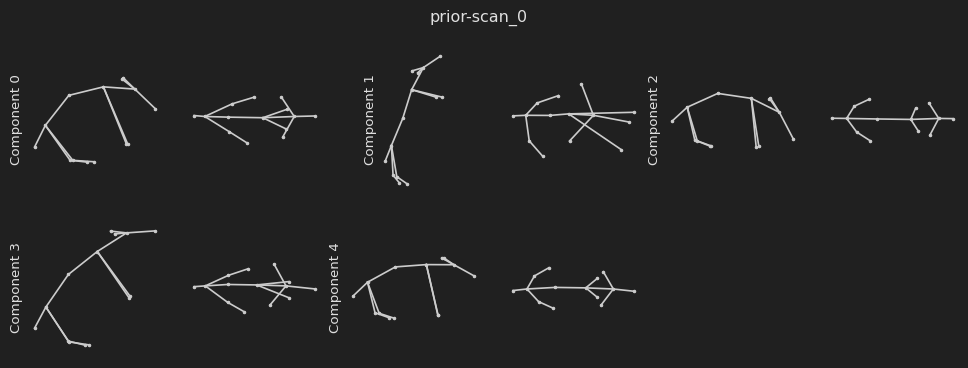

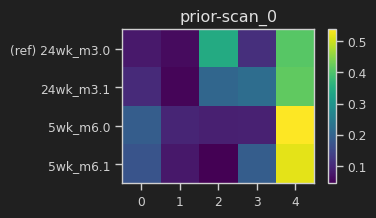

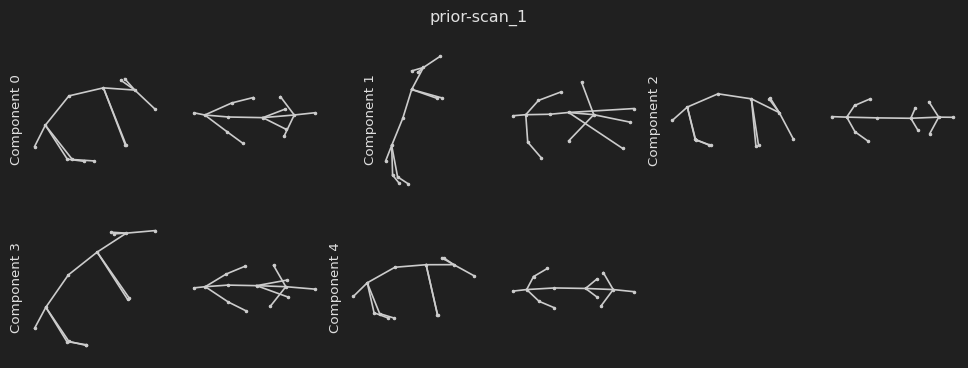

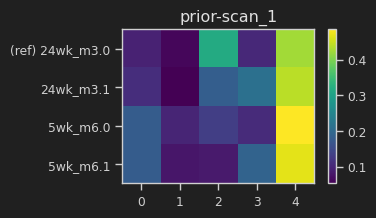

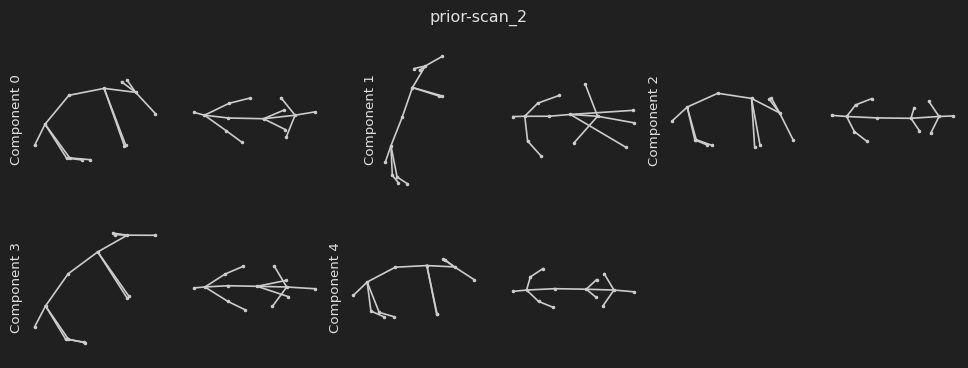

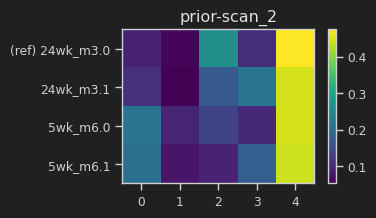

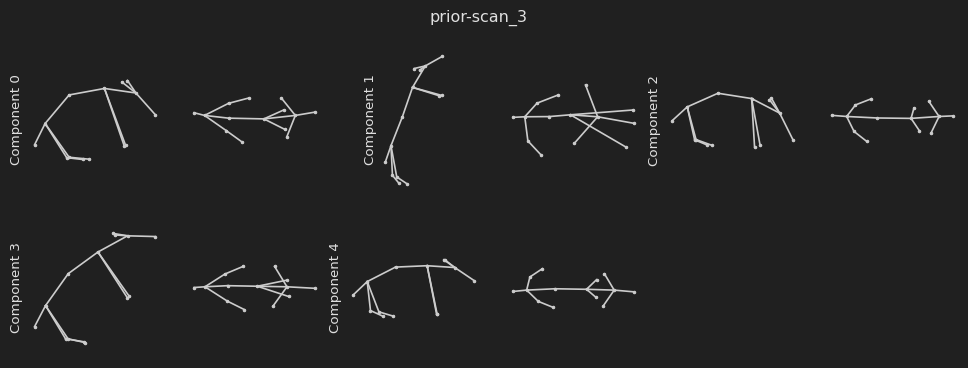

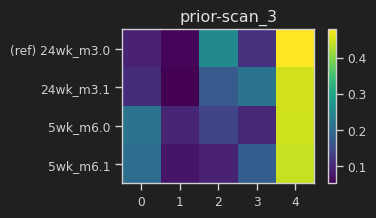

In [20]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg['models'].keys():
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

for model_name in scan_cfg['models'].keys():
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

for model_name in scan_cfg['models'].keys():
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.lra_param_convergence(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

for model_name in scan_cfg['models'].keys():
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.gmm_param_convergence(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

for model_name in scan_cfg['models'].keys():
    ckpt = methods.load_fit(project.model(model_name))
    mean_fig, wt_fig = viz.model.gmm_components(ckpt)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(fig, None)

Reloading 'kpsn.viz.model'.


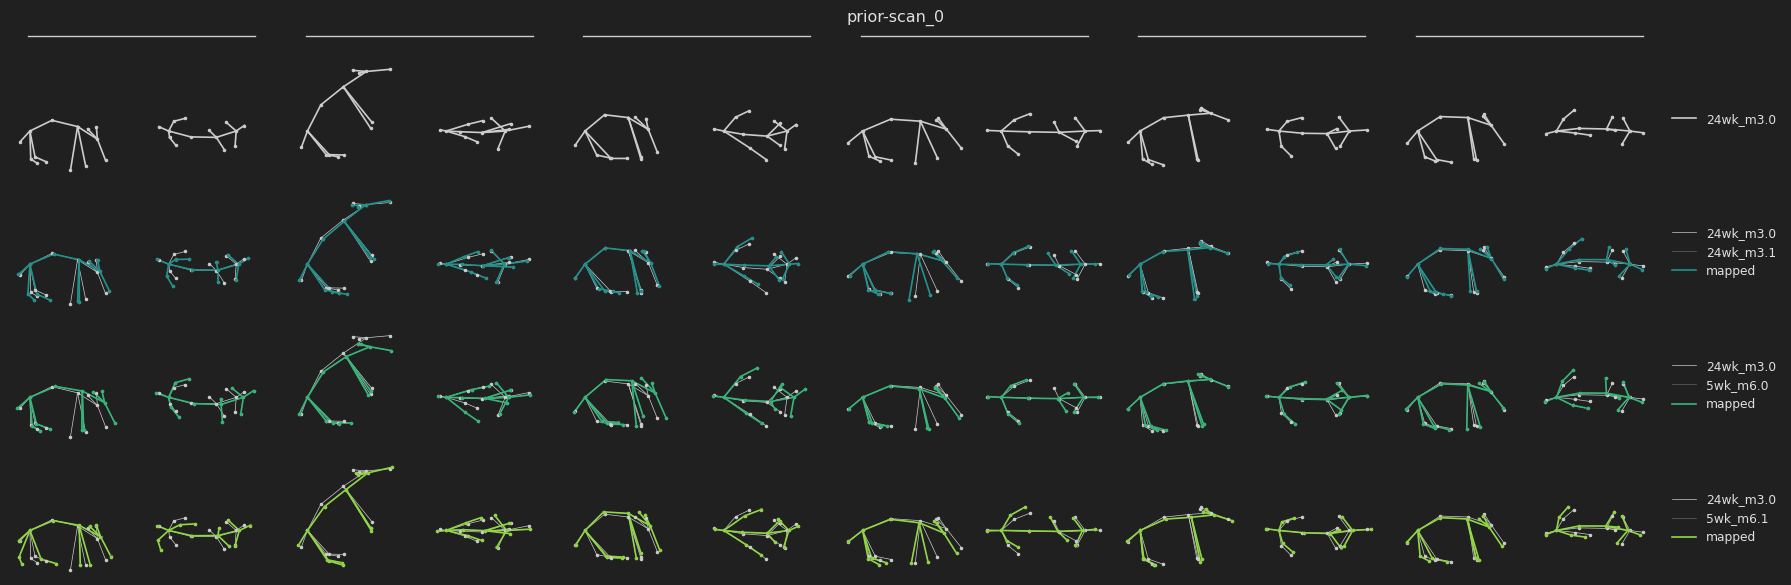

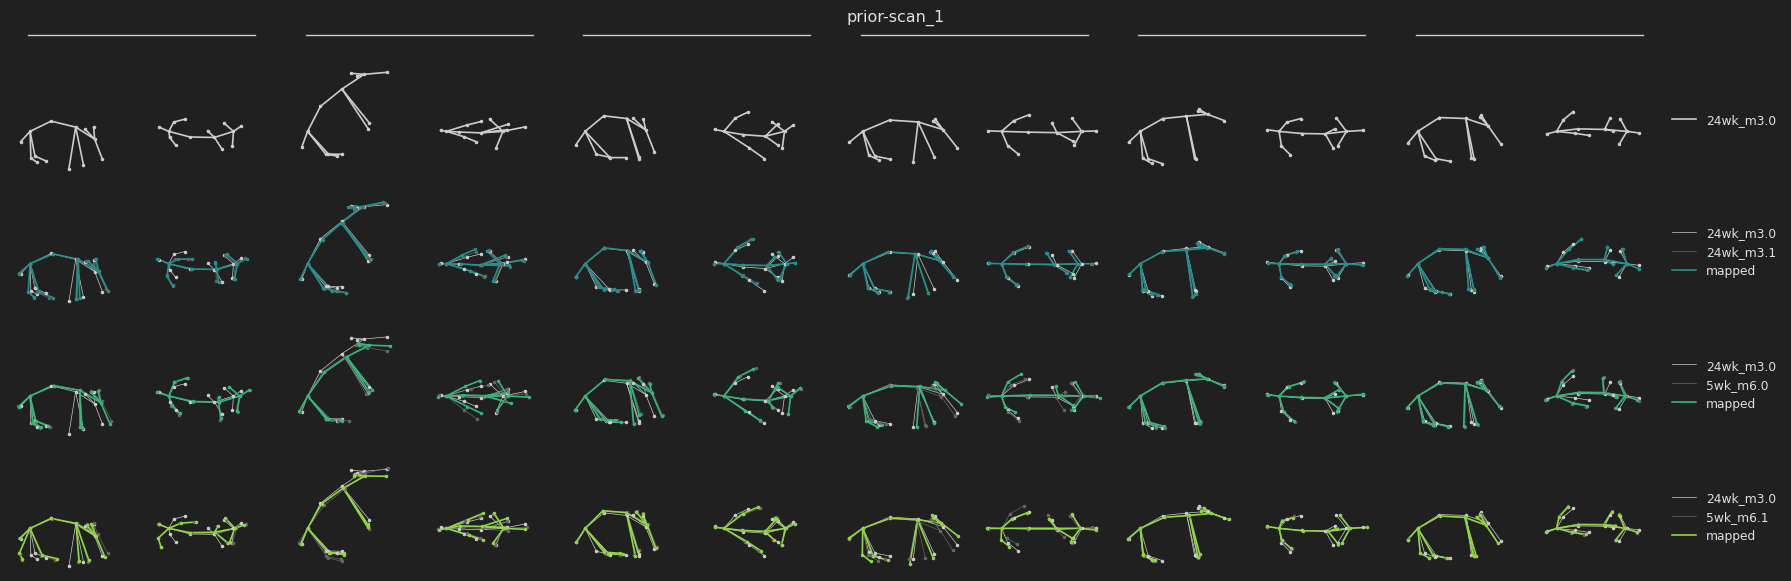

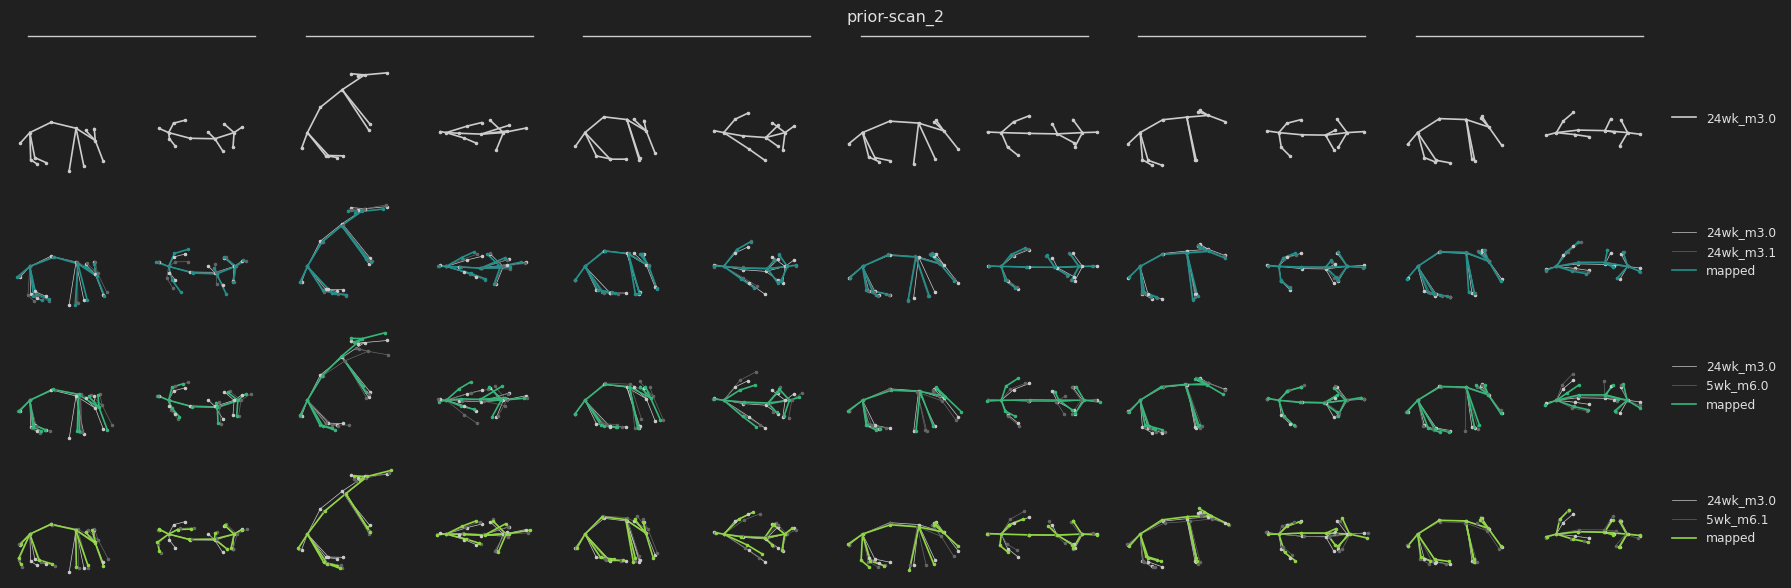

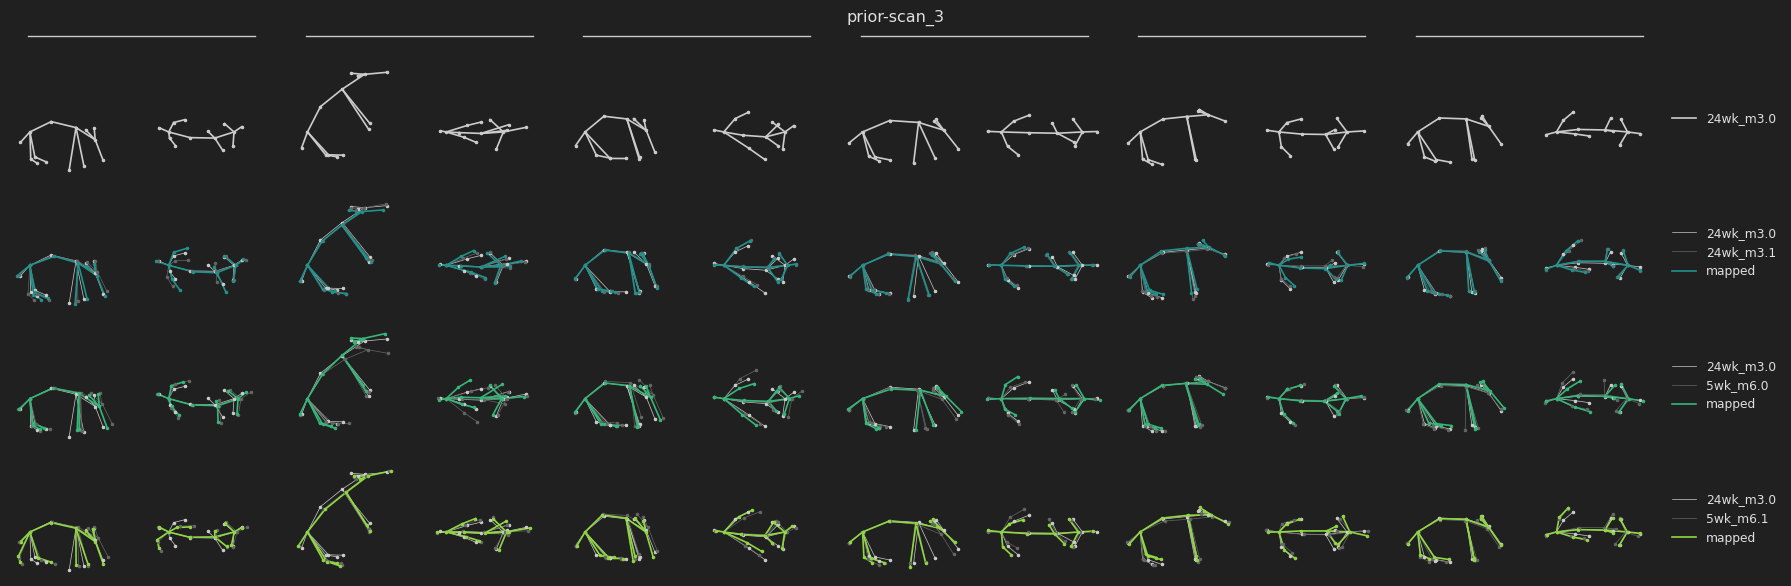

In [24]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg['models'].keys():
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.compare_nearest_frames(ckpt, group_lines=True)
    fig.suptitle(model_name)
    plotter.finalize(fig, None, despine = False, tight=False)

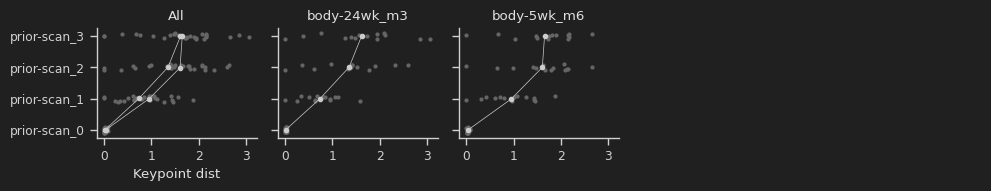

In [25]:
fig = viz.scans.withinbody_reconst_errs(project, "prior-scan")
plotter.finalize(fig, None)

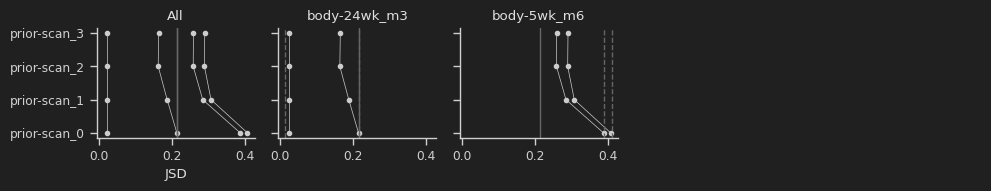

In [26]:
fig = viz.scans.jsds_to_reference(project, "prior-scan")
plotter.finalize(fig, None)

Reloading 'kpsn.viz.model'.


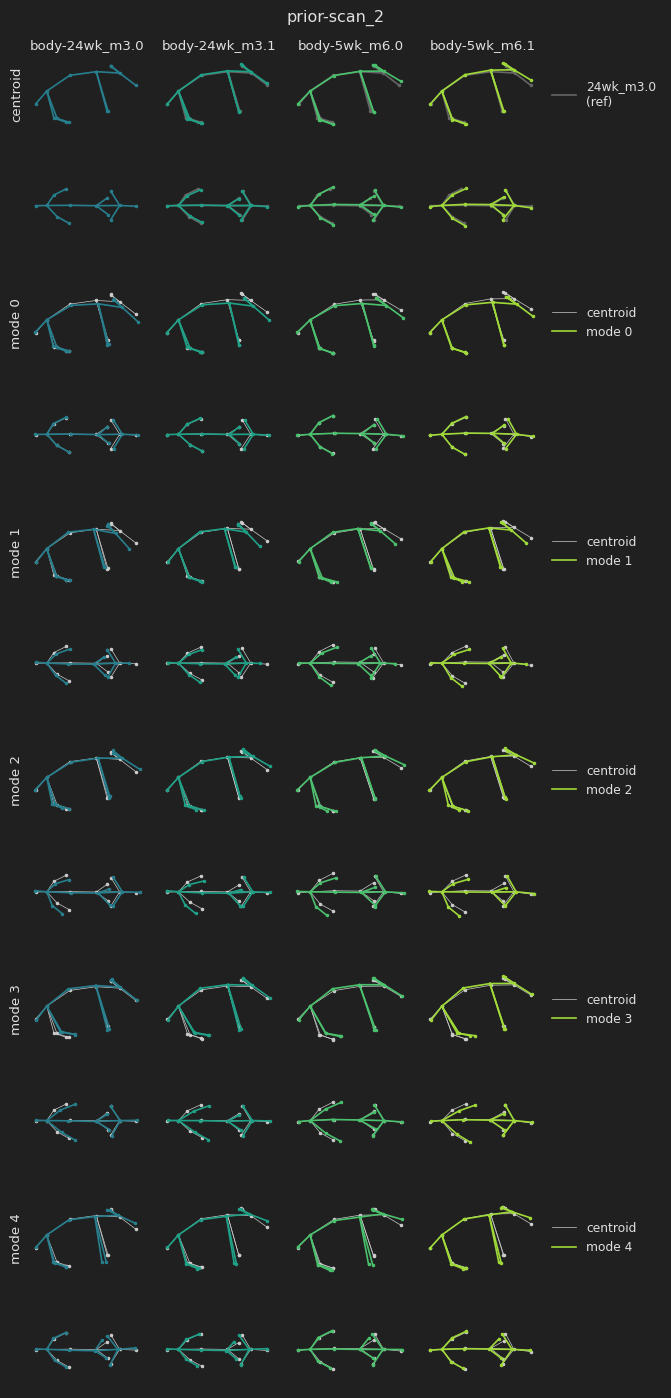

In [52]:
model_name = "prior-scan_2"
ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.lra_centroid_and_modes(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None, despine = False)